# Project

## We upload our csv file containing NAO index values into a pandas dataframe

In [7]:
import pandas as pd

#pandas dataframe containing columns for year, month and index values for NAO
nao = pd.read_csv('/Users/dessyb/Box/Patrick/ERA5/nao.csv') 

## Changing the index of the nao dataframe to a datetime column

In [8]:
import datetime

#placing date variables into a separate dataframe
date_df = nao[["year","month","day"]]

#creating datetime column
dates_column = pd.to_datetime(date_df)

#setting index to datetime variable

nao.index = pd.to_datetime(dates_column)

#viewing first 5 rows of nao dataframe
nao.head()

,year,month,day,index
1979-01-01,1979,1,1,-1.38
1979-02-01,1979,2,1,-0.67
1979-03-01,1979,3,1,0.78
1979-04-01,1979,4,1,-1.71
1979-05-01,1979,5,1,-1.03


## We are interested only in the winter relationship. To facilitate this we create a mask of the indices holding data for winter months DJF

In [9]:
import numpy as np

#creates a variable that identifies season, where winter = 1, spring =2, summer =3, autumn =4
seasons = np.array(nao['month']%12 // 3 + 1)

#transposes seasons to a one dimensional column array
seasons = np.transpose(seasons, axes=None)

#extracting the indices for all winter months (i.e. month == 1)
winter = [i for i, x in enumerate(seasons) if x == 1]

## Adjust years to ensure each winter period reflects the same year

In [10]:
#taking subset of nao index values for winter months only
nao_winter = nao['index'][winter]

#Extracting winter years and months
years = np.array(nao["year"][winter])
months = np.array(nao["month"][winter])

#Decrementing the year for January and February to facilitate grouby.mean
for i in range(len(years)): 
    
    if months[i] == 1 or months[i] == 2:
        
        years[i] -= 1

## Averaging nao index values over each winter season

In [11]:
#Creating dataframe to facilitate grouby.mean
df_smooth = pd.DataFrame({"year":years,"nao":nao_winter})

#Performing mean over each winter period
nao_winter_avg = df_smooth.groupby('year').mean()

#view winter averages
nao_winter_avg.head()

,nao
year,
1978,-1.025000
1979,0.100000
1980,0.690000
1981,0.080000
1982,0.946667


## Recreating the DJF NAO index plot for our dataset (shows below)

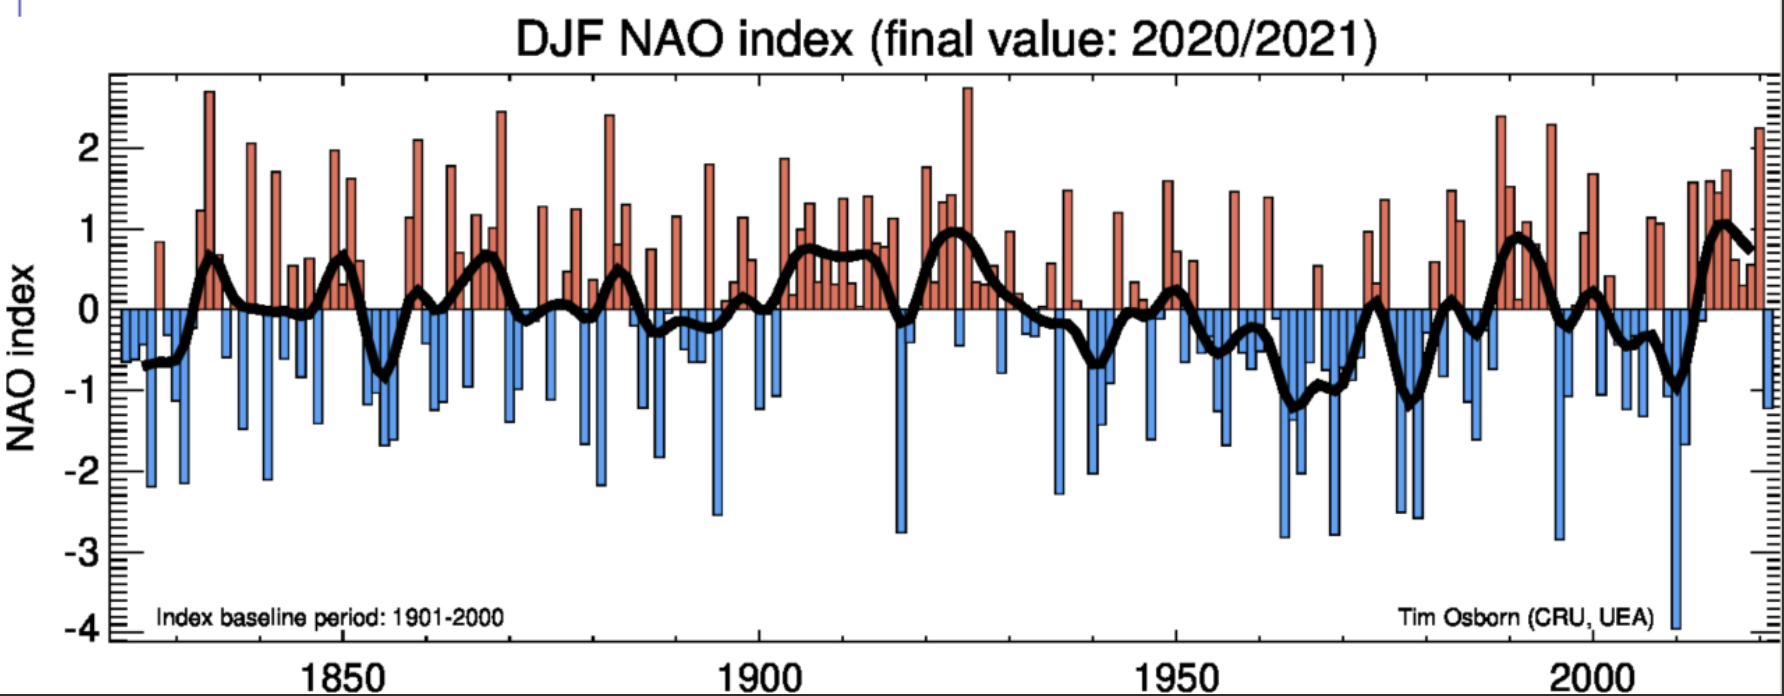

## The above plot features:
### - A histogram of NAO index values averaged over each DJF period 
### - A smoothed line graph of these values
### - A custom y-axis in the form of a ruler
### - Titles and labels

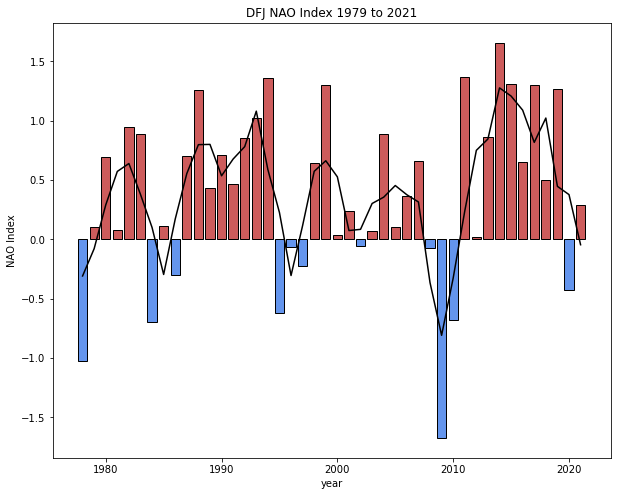

In [12]:
import matplotlib.pyplot as plt

#Defining a smooth function to calculate a running mean
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

#creating an array to store the color of positive (red) vs negative (blue) indices
colors_nao = []

for i in range(len(nao_winter_avg)):
    
    if nao_winter_avg['nao'].iloc[i] >= 0:
        
        colors_nao.append('indianred')
        
    else:
        
        colors_nao.append('cornflowerblue')
        
#creating a callable figure object
fig = plt.figure(figsize=(10, 8))

#Making bar chart
plt.bar(nao_winter_avg.index,nao_winter_avg['nao'],color=colors_nao,edgecolor='black')

#Adding x-axis label
plt.xlabel("year")

#Adding y-axis label
plt.ylabel("NAO Index")

#adding plot title
plt.title("DFJ NAO Index 1979 to 2021")

#Adding a 
plt.plot(nao_winter_avg.index,smooth(nao_winter_avg['nao'],3),color='black', linewidth=1.5)

# plt.plot(nao_winter_avg.index,signal.savgol_filter(nao_winter_avg['nao'], 11, 2),color="black")

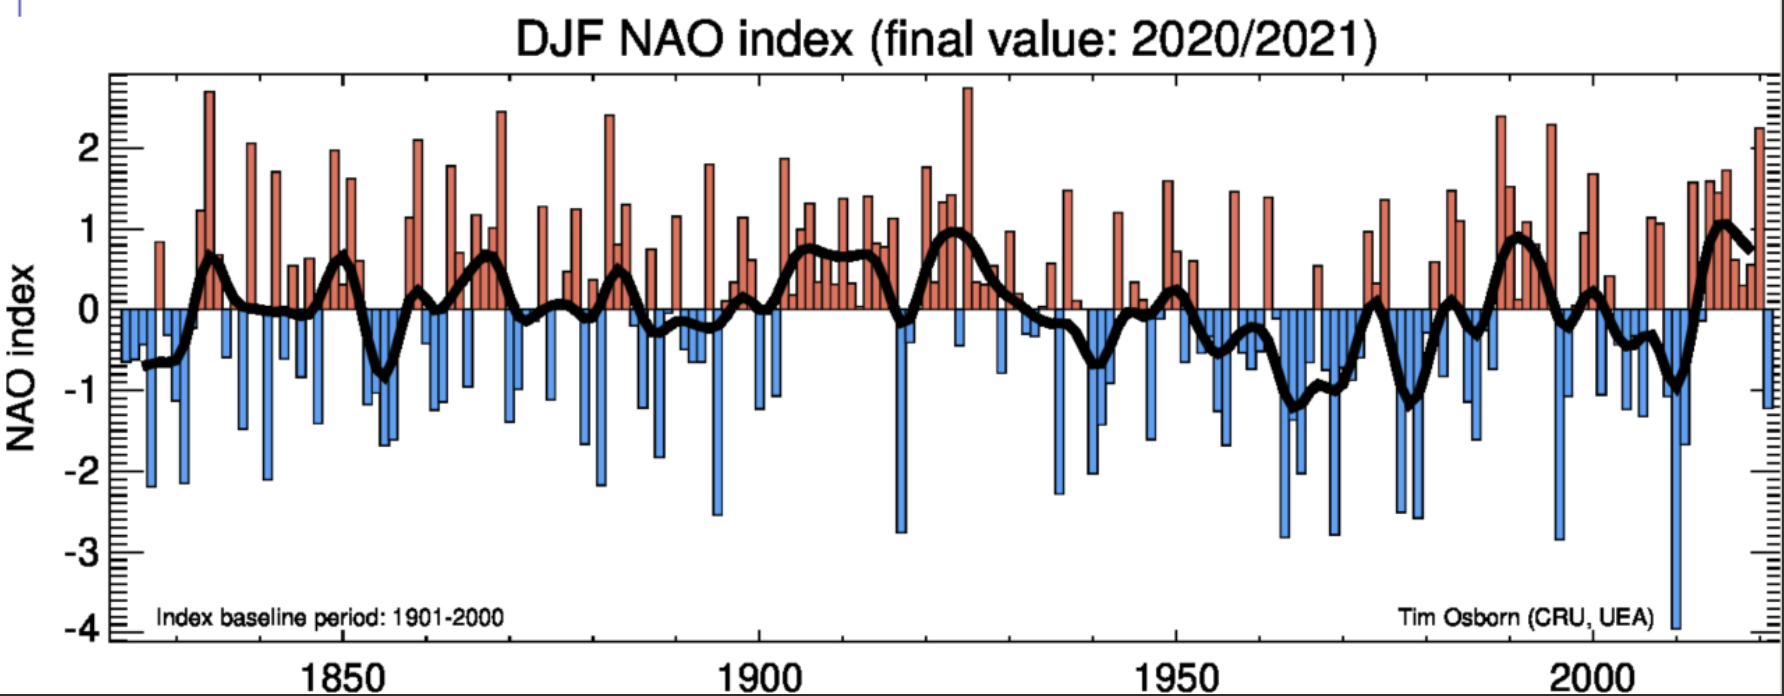

# Our next step is to create a color filled contour plot of the correlation between NAO and SSTs within the Caribbean region
$\text{SST(X,Y)} : X \in (-100^{\circ},-50^{\circ}), Y \in(5,40)$

## We upload our NetCDF file containing SST values within the Caribbean Region into an xarray dataset.

In [13]:
import xarray as xr

#xarray dataset containing gridded SST values
ds = xr.open_dataset('/Users/dessyb/Box/Patrick/ERA5/caribbean_sst.nc') 

#viewing summary of the dataset
ds

<xarray.Dataset>
Dimensions:    (longitude: 201, latitude: 141, expver: 2, time: 516)
Coordinates:
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 ... -50.5 -50.25 -50.0
  * latitude   (latitude) float32 40.0 39.75 39.5 39.25 ... 5.75 5.5 5.25 5.0
  * expver     (expver) int32 1 5
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
Data variables:
    sst        (time, expver, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-01-18 23:23:05 GMT by grib_to_netcdf-2.23.0: /opt/ecmw...

## Creating correlation matrix to store correlation values at each grid point

In [14]:
#length of longitude array in netcdf file
ilon = len(ds.longitude)

#length of latitude array in netcdf file
ilat = len(ds.latitude) 

#matrix for correlations values across grid
corr_matrix = np.array([[np.nan]*ilon]*ilat) 

#double checking that the correlation matrix has the correct dimensions
print(ilat, ilon, corr_matrix.shape)

141 201 (141, 201)


## Populating Correlation matrix by iterating through the correlation matrix

## This requires several steps at each grid point; including:

#### - Removing missing values
#### - Performing a grouby mean
#### - Detrending the SST values
#### - Calculating the Pearson's Correlation coefficent
#### - Set the value at that specific point within the matrix grid

In [15]:
import scipy
from scipy import signal

#for loop calculates correlation across grid
for i in range(ilon): 
    for j in range(ilat):
        
        #putting the year, nao and SST values into a dataframe to facilitate the averageing
        corr_df = pd.DataFrame({'year':years,'nao':nao_winter,'sst':np.array(ds.sst[0:516,0,j,i])[winter]})
        
        #removing missing data
        corr_df = corr_df[corr_df['nao'].notna()]
        corr_df = corr_df[corr_df['sst'].notna()]
        
        #overwriting NaN in corr matrix over water (i.e. if the dataframe has data after removal of NaNs)
        if len(corr_df) > 0:
            
            #performing grouby mean uisng year
            corr_df = corr_df.groupby('year').mean()
            
            #performing detrending of SST values and corr coefficient calculation
            corr_matrix[j][i]=scipy.stats.pearsonr(corr_df['nao'],signal.detrend(corr_df['sst']))[0]

## Creating Contour Plot of Correlation Values

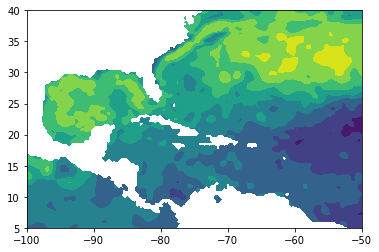

In [16]:
import matplotlib.pyplot as plt

#creating a colour filled contour plot of the correlation matrix
plt.contourf(ds.longitude, ds.latitude,corr_matrix)

## Let's utilize the cartopy library to visually enhance the plot

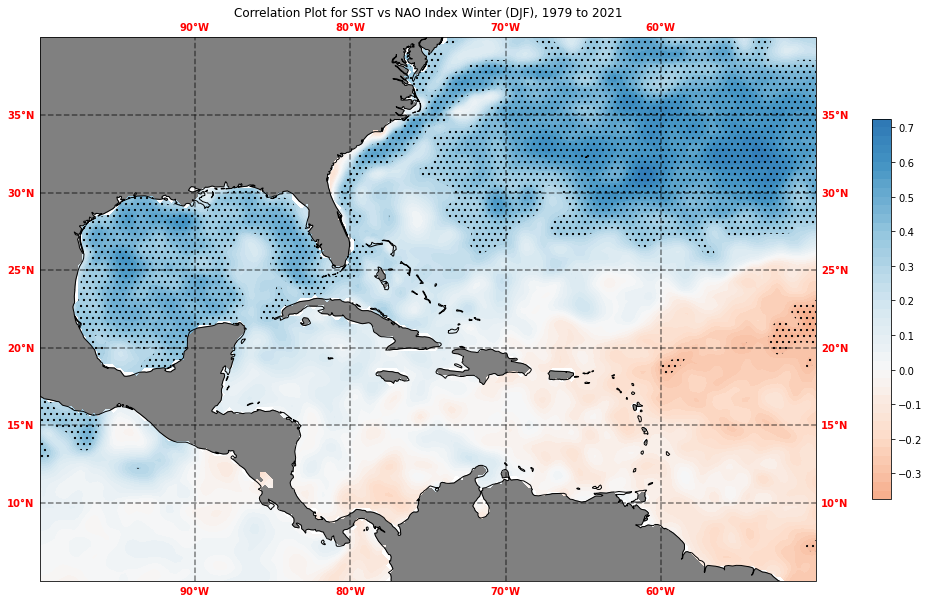

In [23]:
#Defining a function that calculates the critical pearson's correlation coefficient
#based on significance and degrees of freedom

#alpha_level = 0.05

#n = len()
#def pearson_crit(n,alpha):
    
#    df = n-2
    
#    critical_t = scipy.stats.pfp()
    
#    return(((crit_t**2)/(crit_t**2 + df))**0.5)




#create a class to centre the colorbar aound zero (0)
import matplotlib.colors as colors

from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature


import matplotlib.ticker as mticker
import matplotlib.colors as colors

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

class MidpointNormalize(colors.Normalize): #midpoint 
    def __init__(self, vmin=None, vmax=None, vcenter=None, clip=False):
        self.vcenter = vcenter
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        # Note also that we must extrapolate beyond vmin/vmax
        x, y = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1.]
        return np.ma.masked_array(np.interp(value, x, y,
                                            left=-np.inf, right=np.inf))

#defining the range and central point of the colorbar
midnorm = MidpointNormalize(vmin=-1, vcenter=0, vmax=1)

#creating a callable figure object for the plot

fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

#changing land color to grey
ax.add_feature(cfeature.LAND,facecolor=("grey"))

#outlining coastline
ax.add_feature(cfeature.COASTLINE)

#adding latitudinal and longitudinal gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1.5, color='black', alpha=0.5, linestyle='--')

#changing labels on both axis from the default black to red
gl.xlabel_style = {'color': 'red', 'weight': 'bold','size': 10}
gl.ylabel_style = {'color': 'red', 'weight': 'bold','size': 10}

#creating colorbar
#setting the colorbar orientation to vertical (orientation='vertical') 
#setting colobar size to 70% the size of the vertical axis (shrink = 0.7)
#ticks from -1 to 1 in steps of 0.1

#creating color filled contour plot with "RdBu" color scheme
filled_c = ax.contourf(ds.longitude, ds.latitude, corr_matrix,transform=ccrs.PlateCarree(),\
                       cmap='RdBu',levels=50,norm=midnorm)

fig.colorbar(filled_c, orientation='vertical',shrink = 0.7,ticks=np.arange(-1,1,0.1))

#set plot title
plt.title("Correlation Plot for SST vs NAO Index Winter (DJF), 1979 to 2021")



#overlaying a plot of stipples over areas where correlation are significant
ax.contourf(ds.longitude, ds.latitude,corr_matrix,transform=ccrs.PlateCarree(),\
            levels=[-1,-0.3,0.3,1],norm=midnorm,hatches=["..","",".."],alpha=0)

## Let's repeat the process but this time add a 3 point smoother to the winter NAO index data

### First we repeat the calculation of the correlation matrix. However, this time we use smooth the NAO index data by doing a 3 year running average.

In [24]:
#matrix for correlations values across grid
smooth_corr_matrix = np.array([[np.nan]*ilon]*ilat)

#for loop calculates correlation across grid
for i in range(ilon): 
    for j in range(ilat):
        
        #putting the year, nao and SST values into a dataframe to facilitate the averageing
        smooth_corr_df = pd.DataFrame({'year':years,'nao':nao_winter,'sst':np.array(ds.sst[0:516,0,j,i])[winter]})
        
        #removing missing data
        smooth_corr_df = smooth_corr_df[smooth_corr_df['nao'].notna()]
        smooth_corr_df = smooth_corr_df[smooth_corr_df['sst'].notna()]
        
        #overwriting NaN in corr matrix over water (i.e. if the dataframe has data after removal of NaNs)
        if len(smooth_corr_df) > 0:
            
            #performing grouby mean uisng year
            smooth_corr_df = smooth_corr_df.groupby('year').mean()
            
            #performing detrending of SST values and corr coefficient calculation
            smooth_corr_matrix[j][i]=scipy.stats.pearsonr(smooth(smooth_corr_df['nao'],3),signal.detrend(smooth_corr_df['sst']))[0]

### Now we create a new color filled contour plot

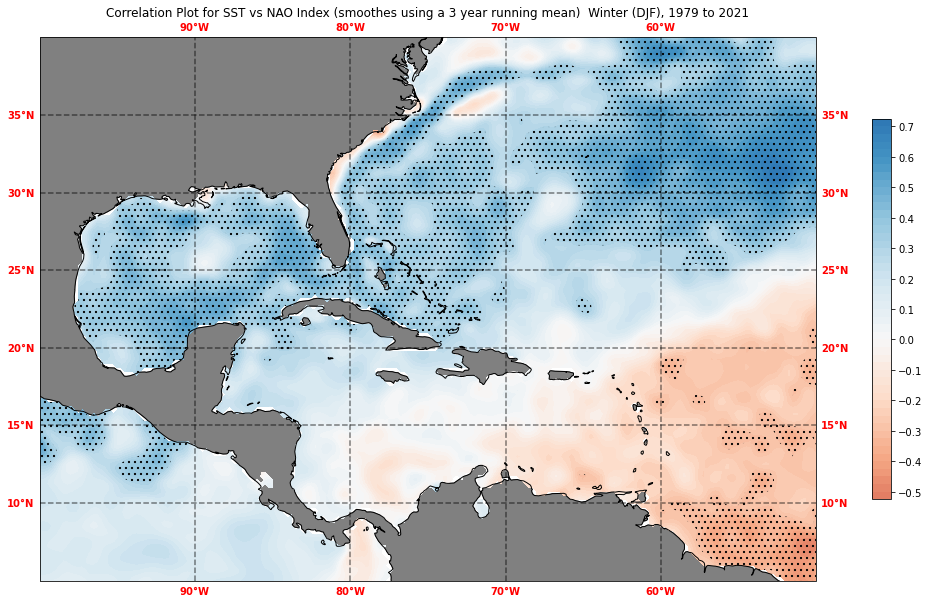

In [25]:
fig2 = plt.figure(figsize=(20, 10))

ax2 = fig2.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

#changing land color to grey
ax2.add_feature(cfeature.LAND,facecolor=("grey"))

#outlining coastline
ax2.add_feature(cfeature.COASTLINE)

#adding latitudinal and longitudinal gridlines
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1.5, color='black', alpha=0.5, linestyle='--')

#changing labels on both axis from the default black to red
gl2.xlabel_style = {'color': 'red', 'weight': 'bold','size': 10}
gl2.ylabel_style = {'color': 'red', 'weight': 'bold','size': 10}

#creating colorbar
#setting the colorbar orientation to vertical (orientation='vertical') 
#setting colobar size to 70% the size of the vertical axis (shrink = 0.7)
#ticks from -1 to 1 in steps of 0.1

#creating color filled contour plot with "RdBu" color scheme
filled_c2 = ax2.contourf(ds.longitude, ds.latitude, smooth_corr_matrix,transform=ccrs.PlateCarree(),\
                       cmap='RdBu',levels=50,norm=midnorm)

fig2.colorbar(filled_c2, orientation='vertical',shrink = 0.7,ticks=np.arange(-1,1,0.1))

#set plot title
plt.title("Correlation Plot for SST vs NAO Index (smoothes using a 3 year running mean)  Winter (DJF), 1979 to 2021")



#overlaying a plot of stipples over areas where correlation are significant
ax2.contourf(ds.longitude, ds.latitude,smooth_corr_matrix,transform=ccrs.PlateCarree(),\
            levels=[-1,-0.3,0.3,1],norm=midnorm,hatches=["..","",".."],alpha=0)

  ## As a sanity check, we average the SST's in selected areas and check the correlation between this average SST and the NAO index over the winter period   

In [39]:
#extracting a slice of the data for the box eclosed by lat 52W-53W and lon 31N-32N
sanity_ds = ds.sel(latitude=slice(35,30),longitude=slice(-60,-55.25))

#extracting only the winter months
sanity_ds = sanity_ds.sst[winter,0,:,:]

#averaging the sliced data over longtiude and latitude (i.e. finding the mean within the box during each winter month)
area_mean =(sanity_ds.mean(dim='longitude')).mean(dim='latitude')

#viewing the data
area_mean

<xarray.DataArray 'sst' (time: 129)>
array([293.37927, 291.80035, 294.95865, 293.39014, 292.4862 , 294.31863,
       293.23816, 292.74902, 294.2046 , 292.64893, 292.09048, 294.46088,
       293.64578, 292.45273, 294.3987 , 293.87558, 292.93524, 294.55344,
       293.15872, 292.27963, 294.5105 , 293.6149 , 292.989  , 295.15686,
       293.71948, 292.8231 , 294.7095 , 293.52335, 293.03348, 294.3881 ,
       293.27435, 293.0038 , 294.6842 , 294.01974, 293.0842 , 294.99713,
       294.19916, 293.5873 , 295.3734 , 293.53564, 292.73538, 294.8372 ,
       293.94766, 292.98764, 295.55594, 294.39368, 293.3387 , 294.9598 ,
       293.49692, 292.71368, 294.44153, 292.88596, 292.68298, 293.93045,
       293.03113, 293.05185, 294.45892, 293.51672, 292.818  , 295.5423 ,
       294.91708, 293.40155, 295.00888, 294.0193 , 293.2589 , 295.19452,
       293.89453, 293.24405, 294.55396, 293.6843 , 292.8636 , 295.22418,
       293.71216, 293.1521 , 295.79556, 294.1778 , 292.8544 , 295.0978 ,
       293.96274, 293.11078, 295.06403, 294.00775, 293.12653, 295.4235 ,
       293.97052, 293.0071 , 294.8706 , 293.8687 , 293.4037 , 295.12848,
       293.9228 , 293.1534 , 294.81265, 292.7733 , 291.9566 , 294.3115 ,
       292.85892, 292.61713, 295.35522, 294.01572, 293.3393 , 295.20953,
       293.48804, 292.45892, 294.79184, 294.0664 , 293.99158, 295.93716,
       294.7028 , 293.65762, 295.57974, 294.5644 , 293.92212, 295.40112,
       294.30344, 293.63193, 296.03293, 294.8847 , 294.1059 , 295.13452,
       293.9187 , 293.66104, 295.62128, 294.0698 , 293.38208, 296.1401 ,
       294.56323, 293.77408,       nan], dtype=float32)
Coordinates:
    expver   int32 1
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01

### Since our last value is NaN, we remove it from out correlation calculation

In [40]:
#calculating correlation between mean SST within the selected box and NAO
scipy.stats.pearsonr(area_mean[0:-1],nao_winter[0:-1])[0]

0.2233644608183064

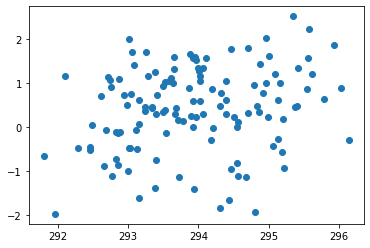

In [41]:
plt.scatter(area_mean[0:-1],nao_winter[0:-1])

# Recreating the DJF NAO index plot for our dataset for JFM instead of the previously calculated DJF

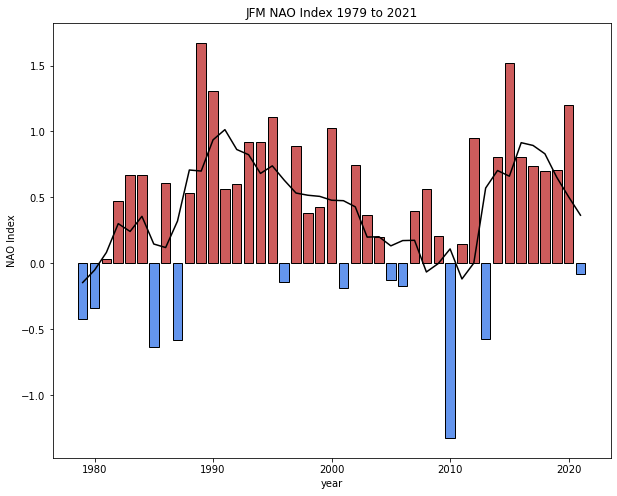

In [42]:
#extracting data for JFM months
JFM = nao[nao['month']<4]

#Creating dataframe to facilitate grouby.mean
JFM_grouped = pd.DataFrame({"year":JFM['year'],"nao":JFM['index']})

#Performing mean over each JFM
JFM_avg = JFM_grouped.groupby('year').mean()

colors_JFM = []

for i in range(len(JFM_avg)):
    
    if JFM_avg['nao'].iloc[i] >= 0:
        
        colors_JFM.append('indianred')
        
    else:
        
        colors_JFM.append('cornflowerblue')
        
#creating a callable figure object
fig = plt.figure(figsize=(10, 8))

#Making bar chart
plt.bar(JFM_avg.index,JFM_avg['nao'],color=colors_JFM,edgecolor='black')

#Adding x-axis label
plt.xlabel("year")

#Adding y-axis label
plt.ylabel("NAO Index")

#adding plot title
plt.title("JFM NAO Index 1979 to 2021")

#Adding a 
plt.plot(JFM_avg.index,smooth(JFM_avg['nao'],5),color='black', linewidth=1.5)

# Recalculating Correlation Matrix and Making Matching Correlation Plots for JFM period

In [43]:
#making an array of the index values for months 


JFM

,year,month,day,index
1979-01-01,1979,1,1,-1.380
1979-02-01,1979,2,1,-0.670
1979-03-01,1979,3,1,0.780
1980-01-01,1980,1,1,-0.750
1980-02-01,1980,2,1,0.050
...,...,...,...,...
2020-02-01,2020,2,1,1.260
2020-03-01,2020,3,1,1.010
2021-01-01,2021,1,1,-1.110
2021-02-01,2021,2,1,0.136


In [61]:
JFM_corr_matrix = np.array([[np.nan]*ilon]*ilat) 

#for loop calculates correlation across grid
for i in range(ilon): 
    for j in range(ilat):
        
        sst_vals = np.array(ds.sst[0:516,0,j,i])
        
        print(len(sst_vals))
        
        
        
        df5 = pd.DataFrame({"year":nao["year"],"month":nao["month"],"nao":nao["index"],"sst":sst_vals})

        JFM = df5[df5["month"]<4]
        
        JFM = JFM[JFM["sst"].notna()]
        
        if len(JFM) > 0:
            
            #performing grouby mean uisng year
            JFM_grouped = JFM_grouped.groupby('year').mean()
            
            #performing detrending of SST values and corr coefficient calculation
            JFM_corr_matrix[j][i]=scipy.stats.pearsonr(JFM_grouped['nao'],signal.detrend(JFM_grouped['sst']))[0]

516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516


KeyError: 'sst'

In [153]:
JFM_corr_matrix.shape

array([[        nan,         nan,         nan, ..., -0.25912879,
        -0.25912879, -0.25912879],
       [        nan,         nan,         nan, ..., -0.25912879,
        -0.25912879, -0.25912879],
       [        nan,         nan,         nan, ..., -0.25912879,
        -0.25912879, -0.25912879],
       ...,
       [-0.25912879, -0.25912879, -0.25912879, ..., -0.25912879,
        -0.25912879, -0.25912879],
       [-0.25912879, -0.25912879, -0.25912879, ..., -0.25912879,
        -0.25912879, -0.25912879],
       [-0.25912879, -0.25912879, -0.25912879, ..., -0.25912879,
        -0.25912879, -0.25912879]])

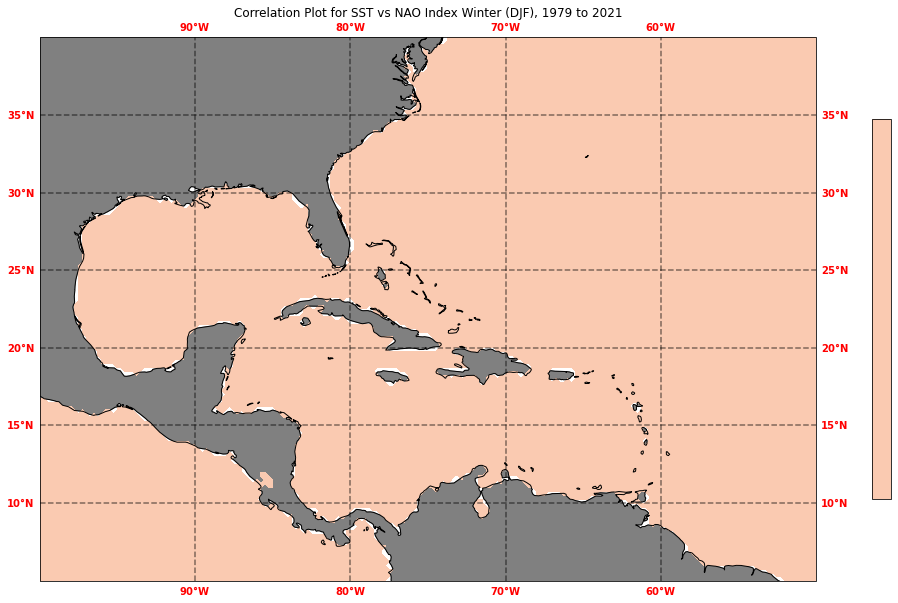

In [152]:
fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

#changing land color to grey
ax.add_feature(cfeature.LAND,facecolor=("grey"))

#outlining coastline
ax.add_feature(cfeature.COASTLINE)

#adding latitudinal and longitudinal gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1.5, color='black', alpha=0.5, linestyle='--')

#changing labels on both axis from the default black to red
gl.xlabel_style = {'color': 'red', 'weight': 'bold','size': 10}
gl.ylabel_style = {'color': 'red', 'weight': 'bold','size': 10}

#creating colorbar
#setting the colorbar orientation to vertical (orientation='vertical') 
#setting colobar size to 70% the size of the vertical axis (shrink = 0.7)
#ticks from -1 to 1 in steps of 0.1

#creating color filled contour plot with "RdBu" color scheme
filled_c = ax.contourf(ds.longitude, ds.latitude, JFM_corr_matrix,transform=ccrs.PlateCarree(),\
                       cmap='RdBu',levels=50,norm=midnorm)

fig.colorbar(filled_c, orientation='vertical',shrink = 0.7,ticks=np.arange(-1,1,0.1))

#set plot title
plt.title("Correlation Plot for SST vs NAO Index Winter (DJF), 1979 to 2021")



#overlaying a plot of stipples over areas where correlation are significant
ax.contourf(ds.longitude, ds.latitude,JFM_corr_matrix,transform=ccrs.PlateCarree(),\
            levels=[-1,-0.3,0.3,1],norm=midnorm,hatches=["..","",".."],alpha=0)

# Goal - recalculate correlation matrix for JFM

# Download Data and Calculate Data for Low Level Stability, Lower Level Winds, and see how much that correllates with the NAO

# (A) Investigate the patterns in the frequency occurence of low cloud types within the Caribbean Region

### (B) Identify Patterns in the low cloud frequencies time series (What does pattern mean????)

### (C) Do the differences in patterns have a pattern (Are the patterns similar location-wise???)

### (D) Can the patterns be explained by climate modes; such as NAO, ENSO, etc (How do we measure this??? maybe correlation with indices or variables)

# End goal discover waves/modes/relations of climate oscillations/modes in the low cloud record of Caribbean Clouds

# Are the trends in the Caribbean low cloud record "real"?
### - Are they similar from station to station - question??? what do we mean by similarity
### - Are the related to trends in variables that are known to control cloudiness? eg SST, low level stability
### - Is the relationship sensible? (similar to the controls operating at other time scales)
### - Can we extrapolate from the trend?